In [3]:
from PDE_FIND3 import * 
from model_selection_IP3 import *

import time, glob
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import numpy as np
import matplotlib.pyplot as plt
import os
import pdb

#increase font size throughout
font = {'size'   : 25}
plt.rc('font', **font)

## Load in Saved ABM Data

([], <a list of 0 Text yticklabel objects>)

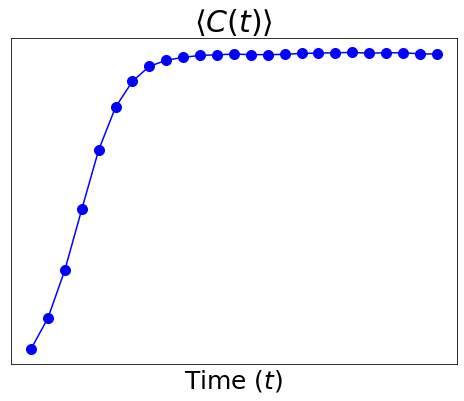

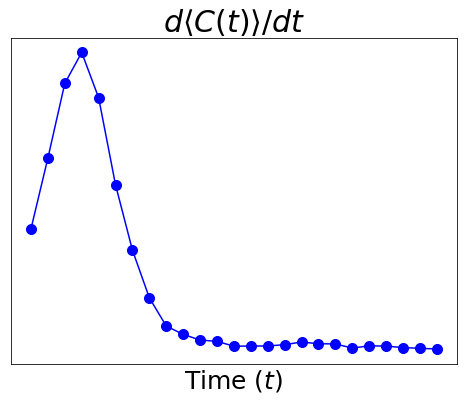

In [4]:
#Load in Data
mat = np.load("../data/logistic_ABM_sim_rp_0.01_rd_0.005_real50.npy",allow_pickle=True, encoding='latin1').item()

#Time
t = mat['variables'][0]
#ABM output
ABM = mat['variables'][1]
#derivative of output
ABM_t = mat['variables'][2]

#plot ABM output
fig = plt.figure(figsize=(8,6))
plt.plot(t[::4],ABM[::4],'b.-',markersize=20)
plt.xlabel('Time ($t$)')
plt.title(r'$\langle C(t) \rangle$')
plt.xticks([])
plt.yticks([])
#plt.savefig("figures/ABM_tutorial_1.pdf",format="pdf")

#plot estimated ABM output time derivative
fig = plt.figure(figsize=(8,6))
plt.plot(t[::4],ABM_t[::4],'b.-',markersize=20)
plt.xlabel('Time ($t$)')
plt.title(r'$d \langle C(t) \rangle / dt$')
plt.xticks([])
plt.yticks([])
#plt.savefig("figures/ABM_tutorial_2.pdf",format="pdf")

## Let's do some EQL (with full linear regression)

Library terms are 
['C^1', 'C^2', 'C^3', 'C^4']

Learned equation from regression is:
dC/dt = 0.00486C^1    - 0.01164C^2    + 0.00721C^3    - 0.00734C^4   


Text(0, 0.5, 'Density')

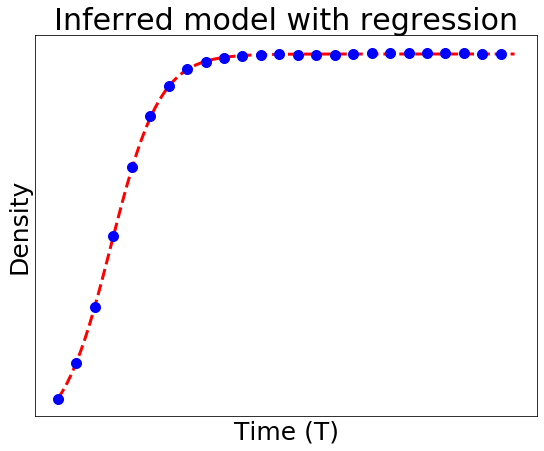

In [5]:
#initialize library of potential RHS terms (polynomials)
Theta = ABM
description = ['C^1']

#up to what order polynomials do we want?
deg = 4

for i in np.arange(2,deg+1):
    Theta = np.hstack([Theta,ABM**i])
    description.append('C^'+str(i))
    
print("Library terms are ")
print(description)
print("")
#perform linear regression
xi = np.linalg.lstsq(Theta,ABM_t,rcond=-1)[0]
print("Learned equation from regression is:")
print(print_pde(xi,description,n=5,ut="dC/dt"))


#Simulate the learned equation and compare to ABM output
RHS = learned_RHS_ODE
u_sim = ODE_sim(xi,RHS,t,ABM[0],description=description,deg=deg)

plt.figure(figsize=(9,7))
plt.plot(t,u_sim.T,'r--',linewidth=3,label='Learned model')
plt.plot(t[::4],ABM[::4],'b.',markersize=20,label='ABM data')
plt.xticks([])
plt.yticks([])
plt.title("Inferred model with regression")
plt.xlabel('Time (T)')
plt.ylabel("Density")

#plt.savefig("figures/ABM_tutorial_3.pdf",format="pdf")

## Let's do EQL with Lasso

Learned equation from regression is:
dC/dt = 0.00468C^1    - 0.00951C^2   


/usr/local/lib/python3.7/site-packages/scipy/integrate/_ode.py:1172: ComplexWarning: Casting complex values to real discards the imaginary part
  tuple(self.call_args) + (f_params,)))


Text(0, 0.5, 'Density')

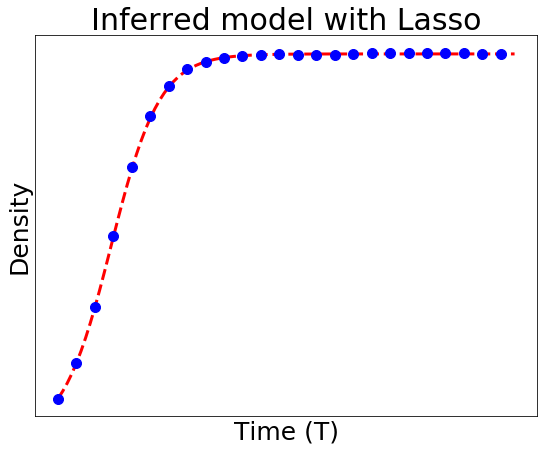

In [6]:
xi = Lasso(Theta,ABM_t,4e-4)
#xi = FoBaGreedy(Theta,ABM_t,1.025e-4)
print("Learned equation from regression is:")
print(print_pde(xi,description,n=5,ut="dC/dt"))

RHS = learned_RHS_ODE
u_sim = ODE_sim(xi,RHS,t,ABM[0],description=description,deg=deg)

plt.figure(figsize=(9,7))
plt.plot(t,u_sim.T,'r--',linewidth=3,label='Learned model')
plt.plot(t[::4],ABM[::4],'b.',markersize=20,label='ABM data')
plt.xticks([])
plt.yticks([])
plt.title("Inferred model with Lasso")
plt.xlabel('Time (T)')
plt.ylabel("Density")

#plt.savefig("figures/ABM_tutorial_4.pdf",format="pdf")

## Let's do Hyperparameter selection with Lasso (but no pruning yet)

In [9]:
#We will learn ten equations using ten different training-testing splits

#percentage of data points in testing & training set
train_perc = 0.5
test_perc = 1.0 - train_perc

for i in np.arange(10):
    
    utTrain,thetaTrain,ptrain,utTest,thetaTest,pTest,_,_,_ = data_shuf(ABM_t,Theta,"perm",train_perc,test_perc,len(t),1)

    xi, hparams, val_score, num_nonzero_u = run_PDE_Find_train_val(thetaTrain,
                                                utTrain,
                                                thetaTest,
                                                utTest,
                                                "Lasso",
                                                description,
                                                lambda_lb=-5,
                                                lambda_ub=-3)
    print("hyperparameter: "+ str(hparams))
    print("Learned Equation " + str(i+1) + ":")
    print(print_pde(xi,description,ut="dC/dt"))
    print("")

hyperparameter: 3.39322177189533e-05
Learned Equation 1:
dC/dt = 0.00468C^1    - 0.00951C^2   

hyperparameter: 0.0
Learned Equation 2:
dC/dt = 0.00487C^1    - 0.01196C^2    + 0.00858C^3    - 0.00896C^4   

hyperparameter: 4.094915062380427e-05
Learned Equation 3:
dC/dt = 0.0047C^1    - 0.00955C^2   

hyperparameter: 0.0
Learned Equation 4:
dC/dt = 0.00489C^1    - 0.01201C^2    + 0.00821C^3    - 0.00814C^4   

hyperparameter: 0.0
Learned Equation 5:
dC/dt = 0.00477C^1    - 0.01079C^2    + 0.00457C^3    - 0.00481C^4   

hyperparameter: 3.727593720314938e-05
Learned Equation 6:
dC/dt = 0.00467C^1    - 0.0095C^2   

hyperparameter: 0.0
Learned Equation 7:
dC/dt = 0.00491C^1    - 0.01224C^2    + 0.00898C^3    - 0.00892C^4   

hyperparameter: 0.0
Learned Equation 8:
dC/dt = 0.00475C^1    - 0.0107C^2    + 0.00456C^3    - 0.00503C^4   

hyperparameter: 2.811768697974231e-05
Learned Equation 9:
dC/dt = 0.00467C^1    - 0.00946C^2    - 5e-05C^3   

hyperparameter: 0.0
Learned Equation 10:
dC/dt 

## Let's do Hyperparameter selection with Lasso and pruning

In [11]:
#We will learn ten equations using ten different training-testing splits

#percentage of data points in testing & training set
train_perc = 0.5
test_perc = 1.0 - train_perc

#Pruning percentage
prune_level = 0.05

for i in np.arange(10):
    
    utTrain,thetaTrain,ptrain,utTest,thetaTest,pTest,_,_,_ = data_shuf(ABM_t,Theta,"perm",train_perc,test_perc,len(t),1)

    xi, hparams, val_score, num_nonzero_u = run_PDE_Find_train_val(thetaTrain,
                                                utTrain,
                                                thetaTest,
                                                utTest,
                                                "Lasso",
                                                description,
                                                lambda_lb=-5,
                                                lambda_ub=-3)

    
    #perform pruning
    if len(xi[xi!=0]) > 1:
        xi, val_score_new = PDE_FIND_prune_lstsq(xi,utTrain,utTest,thetaTrain,thetaTest,description,np.min(val_score),prune_level)
    
    print("Learned Equation " + str(i+1) + ":")
    print(print_pde(xi,description,ut="dC/dt"))
    print("")

Learned Equation 1:
dC/dt = 0.00483C^1    - 0.01124C^2    + 0.00569C^3    - 0.00573C^4   

Learned Equation 2:
dC/dt = 0.0049C^1    - 0.01178C^2    + 0.00706C^3    - 0.00687C^4   

Learned Equation 3:
dC/dt = 0.0047C^1    - 0.00956C^2   

Learned Equation 4:
dC/dt = 0.00467C^1    - 0.0095C^2   

Learned Equation 5:
dC/dt = 0.00466C^1    - 0.00946C^2   

Learned Equation 6:
dC/dt = 0.00468C^1    - 0.00952C^2   

Learned Equation 7:
dC/dt = 0.00467C^1    - 0.00949C^2   

Learned Equation 8:
dC/dt = 0.00482C^1    - 0.01102C^2    + 0.00489C^3    - 0.0049C^4   

Learned Equation 9:
dC/dt = 0.00468C^1    - 0.00952C^2   

Learned Equation 10:
dC/dt = 0.00467C^1    - 0.00949C^2   

